<a href="https://colab.research.google.com/github/gtsagkatakis/ADAX-datathon/blob/main/ADAX_datathon_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
from keras import regularizers
import skimage.measure
import sys

In [19]:
# download the dataset from here
#https://drive.google.com/open?id=1xUvbtmOx2RTEGQOIm9QJzqL3QZX7KbXr&usp=drive_fs

In [20]:
!gdown '1xV0yZCLc5wYbT7mxlANxVGDnzg0dVxJC'


Downloading...
From: https://drive.google.com/uc?id=1xV0yZCLc5wYbT7mxlANxVGDnzg0dVxJC
To: /content/train_data_10k.npy
100% 71.2M/71.2M [00:00<00:00, 252MB/s]


In [21]:
spectral_data=np.load('train_data_10k.npy')

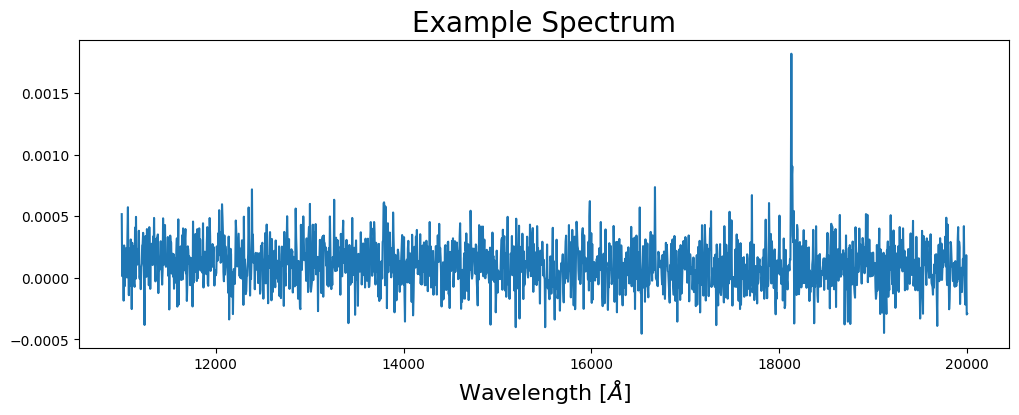

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(11000, 20000, 1780), spectral_data[1000])
plt.title('Example Spectrum', fontsize=20)
plt.xlabel(f'Wavelength [$\\AA$]', fontsize=16)
plt.show()

In [23]:
!gdown '1xVbpQEU7zgbDqloeujlxHPE61UeZFdCd'


Downloading...
From: https://drive.google.com/uc?id=1xVbpQEU7zgbDqloeujlxHPE61UeZFdCd
To: /content/trainLabels_10k.npy
100% 32.0M/32.0M [00:00<00:00, 257MB/s]


In [24]:
redshift_labels=np.load('trainLabels_10k.npy')

In [25]:
#make 800 classes -> 80
#redshift_labels=skimage.measure.block_reduce(redshift_labels, (1,10), np.max)

In [26]:
#collect training data
num_training_examples=5000
train_data=spectral_data[0:num_training_examples,:]
train_labels=redshift_labels[0:num_training_examples,:]


In [27]:
#collect test data
test_data=spectral_data[9000:10000,:]
test_labels=redshift_labels[9000:10000,:]


In [28]:
#create a function to plot the loss and accuracy during training
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.losses2 = []
        self.val_losses2 = []


        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('categorical_accuracy'))
        self.val_losses.append(logs.get('val_categorical_accuracy'))
        self.losses2.append(logs.get('loss'))
        self.val_losses2.append(logs.get('val_loss'))

        self.i += 1

        clear_output(wait=True)
        plt.subplot(1,2,1)
        plt.plot(self.x, self.losses, label="Training accuracy",linestyle='-')
        plt.plot(self.x, self.val_losses, label="Testing accuracy",linestyle='--')
        plt.ylim(0,1)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
#        plt.savefig('acc.png',dpi=300)

        plt.subplot(1,2,2)
        plt.plot(self.x, self.losses2, label="Training loss",linestyle='-')
        plt.plot(self.x, self.val_losses2, label="Testing loss",linestyle='--')
#        plt.ylim(0,1)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.tight_layout()

        plt.show();

plot_losses = PlotLosses()



In [29]:
#define the DNN

inputs = Input((train_data.shape[1],1),name='main_input')

conv00  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(inputs)
#conv01  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(conv00)
pool00  = MaxPooling1D(pool_size=3, strides=2, padding='same')(conv00)
bn00 = BatchNormalization()(pool00)

conv10  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(bn00)
#conv11  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(conv10)
pool10  = MaxPooling1D(pool_size=3, strides=2, padding='same')(conv10)
bn10 = BatchNormalization()(pool10)

conv20  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(bn10)
#conv21  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(conv20)
pool20  = MaxPooling1D(pool_size=3, strides=2, padding='same')(conv20)
bn20 = BatchNormalization()(pool20)
#conv30  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(pool20)
#conv21  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(conv20)
#pool30  = MaxPooling1D(pool_size=1, strides=1, padding='same')(conv30)

#conv40  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(pool30)
#conv21  = Conv1D(16, 8,  activation='relu', strides=1, padding='same')(conv20)
#pool40  = MaxPooling1D(pool_size=1, strides=1, padding='same')(conv40)



fl0 = Flatten(name='fl0')(bn20)

Do0 = Dropout(0.5)(fl0)

fc0  = Dense(512,activation='linear', kernel_regularizer=regularizers.l2(0.2))(Do0)

Do1 = Dropout(0.5)(fc0)

Dn0 = Dense(train_labels.shape[1],activation='softmax', name='Dn0' )(Do1)
#Dn0 = Dense(1,activation='linear', name='Dn0' )(Do1)

model_1 = Model(inputs=[inputs], outputs=[Dn0])
optzr =  Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)


#model_1.compile(loss='mean_absolute_error',optimizer=optzr,  metrics =['mean_absolute_error'])
model_1.compile(loss='categorical_crossentropy',optimizer=optzr,  metrics =['categorical_accuracy'])

model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 1780, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1780, 16)          144       
                                                                 
 max_pooling1d (MaxPooling1  (None, 890, 16)           0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 890, 16)           64        
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 890, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 445, 16)           0     

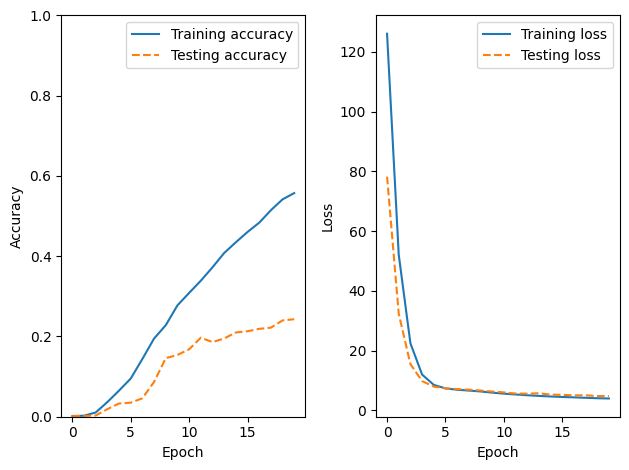

157/157 [==============================] - 3s 16ms/step - loss: 4.0051 - categorical_accuracy: 0.5574 - val_loss: 4.8252 - val_categorical_accuracy: 0.2430


In [30]:
#traing the model
history=model_1.fit(train_data,train_labels, batch_size=32, epochs=20, validation_data=[test_data,test_labels],callbacks=[plot_losses],shuffle=True)


In [31]:
test_labels_max=np.argmax(test_labels,1)
test_labels_reg=np.argmax(test_labels,1)
test_labels_reg=1+test_labels_reg*0.01
print('min:',np.amin(test_labels_reg),' max:', np.amax(test_labels_reg),' unique:', np.unique(test_labels_reg).size)

predictions = model_1.predict(test_data)
predictions_max=np.argmax(predictions,1)
predictions_red=1+predictions_max*0.01
print('min:',np.amin(predictions_red),' max:', np.amax(predictions_red),' unique:', np.unique(predictions_red).size)

error=np.mean(abs(predictions_red - test_labels_reg))

print('Mean prediction error:', error)

min: 1.0  max: 8.99  unique: 573
32/32 [==============================] - 0s 2ms/step
min: 1.01  max: 8.99  unique: 360
Mean prediction error: 0.18045


In [32]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(test_labels_max, predictions_max)


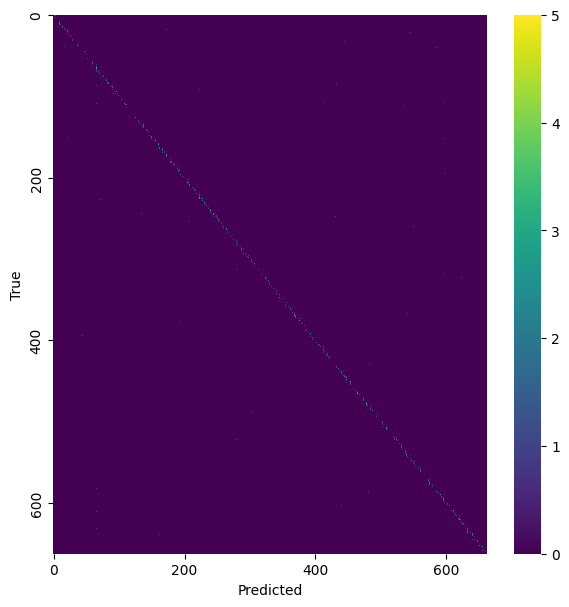

In [33]:
import seaborn as sns
plt.figure(figsize=(7, 7))
sns.heatmap(cm, cmap='viridis', xticklabels=200, yticklabels=200)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()